In [6]:
import csv
import numpy as np
import os
import scipy.stats
import pandas as pd
import sqlite3 as sql
from scipy.stats import chi2_contingency
from matplotlib import pyplot
%matplotlib inline

# Titanic Data Analysis
## Questions to investigate:

The sinking of the Titanic was a true tragedy, leaving over 1,500 of the 2,224 passengers dead. The social status of the passengers ranged from the wealthiest people in the world to those hoping to emigrate to the United States with the promise of a better life. This diversity made the population on board the RMS Titanic was a microcosm of Western Europe in 1912. By analyzing the survival data, I am hoping to understand the effects of agem gender, and social status and the survival of the passengers.

## Loading the Data
### First I am loading the data into a Pandas Data frame.

In [7]:
cwd = os.getcwd()
data_set = os.path.join(cwd,"titanic.db")
conn = sql.connect(data_set)
titanic = pd.read_sql("select * from titanic;", conn)
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
index          891 non-null int64
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(6), object(5)
memory usage: 90.6+ KB


The Age variable contains NaN. There are a number of ways to handle non numeric values for age. I could come up with methods of imputing a value for age. This could be applying the mean age to all of the records without a age value. I could also impute this value with a more sophisticated regression model. Both of these methods could bias any insights I may find. Instead I will remove these records from my dataset.

In [8]:
titanic.dropna(subset=['Age'], inplace=True) # remove all rows from dataframe with Age value of NA

In [9]:
#The mean of the Survived column gives the survival rate of the passsengers from this dataset.

titanic['Survived'].mean() 

0.4061624649859944

## Investigating titles in the dataset

The dataset includes a column the with passenger's title. Titles provide insight to a passenger's social status and gender.

Mr              398
Miss            146
Mrs             108
Master           36
Dr                6
Rev               6
Major             2
Mlle              2
Col               2
Mme               1
Capt              1
Jonkheer          1
Lady              1
the Countess      1
Sir               1
Ms                1
Don               1
Name: Title, dtype: int64

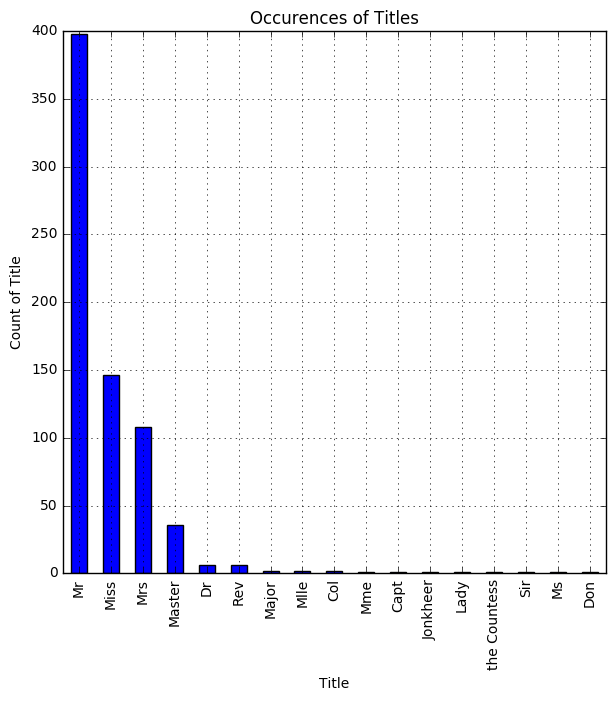

In [10]:

# the format of the Name feature is Last Name, Title. Husband's Given Name (Wife's Maiden Name if applicable)
# lambda function first splits on the comma. It then takes everything from the right of the comma and splits by '.'
# the title should be to the left of the '.'
titanic['Title'] = titanic['Name'].apply(lambda x: x.split(', ')[1].partition('.')[0])
bar_chart = titanic['Title'].value_counts().plot.bar(title ="Occurences of Titles",figsize=(7,7),grid =True)
bar_chart.set(xlabel = "Title",ylabel = "Count of Title")
titanic['Title'].value_counts()


It looks like the transformation for the new feature worked for all cases on the dataset.
There are a few oddities with the dataset. It appears that the french titles Madame (MME) and Mademoiselle (Mlle) were included. These can be easily mapped to Ms and Mrs. There are a few titles which signs of nobility ([ie the Countess and Jonkheer](https://en.wikipedia.org/wiki/Jonkheer))

There is clearly a disproportionate number of Misters vs Miss/Mrs. I will confirm that the sum of the gendered titles match the number of male and female passengers.

In [11]:

#Checking the number of male vs female passengers to confirm that the difference in Male vs. Female titles makes sense.
Sex = titanic.groupby(by=['Sex'])['Sex'].count()
print(Sex)
# concatenating the "female titles"
Female_Titles = titanic['Title'].value_counts()['Miss']\
+titanic['Title'].value_counts()['Mrs']\
+titanic['Title'].value_counts()['Mlle']\
+titanic['Title'].value_counts()['Ms']\
+titanic['Title'].value_counts()['Jonkheer']\
+titanic['Title'].value_counts()['the Countess']\
+titanic['Title'].value_counts()['Mme']\
+titanic['Title'].value_counts()['Lady']\

print("The number of female titles: {}".format(Female_Titles))

# concatenating the "male titles"
Male_Titles = titanic['Title'].value_counts()['Mr']\
+titanic['Title'].value_counts()['Master']\
+titanic['Title'].value_counts()['Dr']\
+titanic['Title'].value_counts()['Rev']\
+titanic['Title'].value_counts()['Major']\
+titanic['Title'].value_counts()['Col']\
+titanic['Title'].value_counts()['Capt']\
+titanic['Title'].value_counts()['Sir']\
+titanic['Title'].value_counts()['Don']\

print("The number of male titles: {}".format(Male_Titles))


Sex
female    261
male      453
Name: Sex, dtype: int64
The number of female titles: 261
The number of male titles: 453


It looks like the passenger count of gender and count of gendered titles match in aggregate.

Next I will investigate how ages are distributed across 

[<matplotlib.text.Text at 0x117870940>, <matplotlib.text.Text at 0x11785d2b0>]

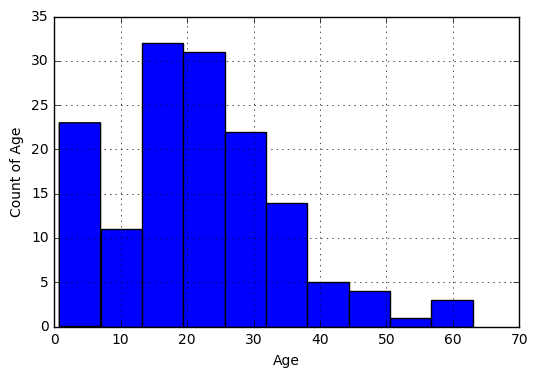

In [12]:
Miss = titanic.loc[titanic['Title']=='Miss']
miss_age_histogram = Miss['Age'].hist()
miss_age_histogram.set(xlabel = "Age",ylabel="Count of Age" )

In [13]:
Miss['Age'].describe()

count    146.000000
mean      21.773973
std       12.990292
min        0.750000
25%       14.125000
50%       21.000000
75%       30.000000
max       63.000000
Name: Age, dtype: float64

The age of Passengers with the title Miss seems to have a large degree of variance. The median age is 21.00 with a standard deviation of 12.99. The youngest passenger with Miss in the title was 9 months old and the oldest was 63 years old.

[<matplotlib.text.Text at 0x1178acfd0>, <matplotlib.text.Text at 0x117883630>]

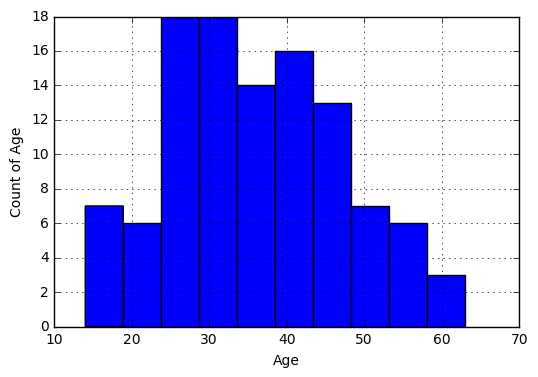

In [14]:
Misses = titanic.loc[titanic['Title']=='Mrs']
misses_age_histogram = Misses['Age'].hist()
misses_age_histogram.set(xlabel = "Age",ylabel="Count of Age" )

In [15]:
Misses['Age'].describe()

count    108.000000
mean      35.898148
std       11.433628
min       14.000000
25%       27.750000
50%       35.000000
75%       44.000000
max       63.000000
Name: Age, dtype: float64

The age of passengers with the title Miss seems to have a slightly smaller degree of variance. The median age is 35.00 with a standard deviation of 11.43. The youngest passenger with Mrs in the title was 14 months old and the oldest was 63 years old.

## Comparing Mrs to Miss

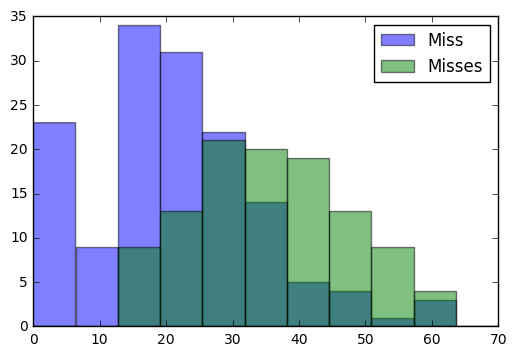

In [16]:
bins = np.linspace(0, 70, 12)

pyplot.hist(Miss['Age'], bins, alpha=.5, label='Miss')
pyplot.hist(Misses['Age'], bins, alpha=.5, label='Misses')
pyplot.legend(loc='upper right')
pyplot.show()

It looks like Misses is distributed more heavily towards the older population. This is reasonable, as these titles are typically related to marital status. One oddity with this data are the records where Misses is under 20 years old. I will drill into these records further

In [31]:
Misses.where(Misses['Age']<20).dropna(subset=['Age'])

,index,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
9,9.0,10.0,1.0,2.0,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1.0,0.0,237736,30.0708,None,C,Mrs
49,49.0,50.0,0.0,3.0,"Arnold-Franchi, Mrs. Josef (Josefine Franchi)",female,18.0,1.0,0.0,349237,17.8000,None,S,Mrs
291,291.0,292.0,1.0,1.0,"Bishop, Mrs. Dickinson H (Helen Walton)",female,19.0,1.0,0.0,11967,91.0792,B49,C,Mrs
307,307.0,308.0,1.0,1.0,"Penasco y Castellana, Mrs. Victor de Satode (M...",female,17.0,1.0,0.0,PC 17758,108.9000,C65,C,Mrs
546,546.0,547.0,1.0,2.0,"Beane, Mrs. Edward (Ethel Clarke)",female,19.0,1.0,0.0,2908,26.0000,None,S,Mrs
700,700.0,701.0,1.0,1.0,"Astor, Mrs. John Jacob (Madeleine Talmadge Force)",female,18.0,1.0,0.0,PC 17757,227.5250,C62 C64,C,Mrs
781,781.0,782.0,1.0,1.0,"Dick, Mrs. Albert Adrian (Vera Gillespie)",female,17.0,1.0,0.0,17474,57.0000,B20,S,Mrs
830,830.0,831.0,1.0,3.0,"Yasbeck, Mrs. Antoni (Selini Alexander)",female,15.0,1.0,0.0,2659,14.4542,None,C,Mrs
855,855.0,856.0,1.0,3.0,"Aks, Mrs. Sam (Leah Rosen)",female,18.0,0.0,1.0,392091,9.3500,None,S,Mrs


Fro the name field, each female with a title of Mrs also has their husband's name. Although this would be highly atypical in 2017, it is not outside of the realm of possiblity in 1912.

[<matplotlib.text.Text at 0x1185d1780>, <matplotlib.text.Text at 0x118509e10>]

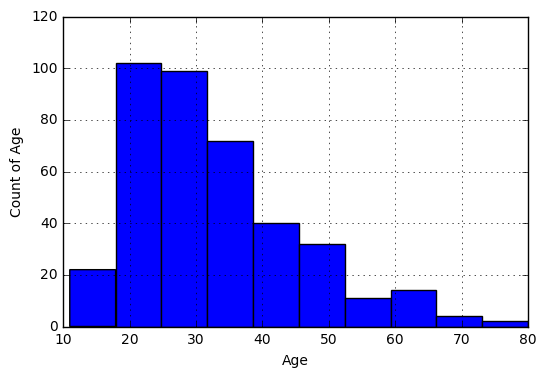

In [18]:
Mister = titanic.loc[titanic['Title']=='Mr']
mister_age_histogram = Mister['Age'].hist()
mister_age_histogram.set(xlabel = "Age",ylabel="Count of Age" )

[<matplotlib.text.Text at 0x1185d1e10>, <matplotlib.text.Text at 0x1185e96d8>]

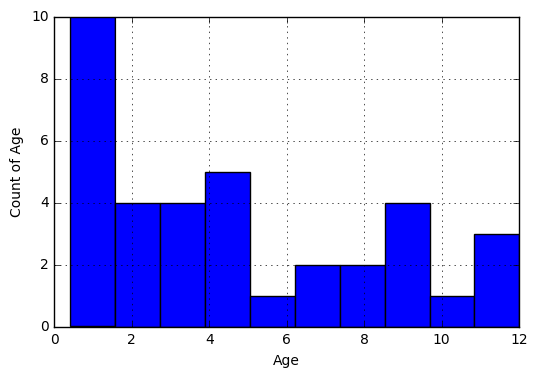

In [19]:
Master = titanic.loc[titanic['Title']=='Master']
master_age_histogram = Master['Age'].hist()
master_age_histogram.set(xlabel = "Age",ylabel="Count of Age" )

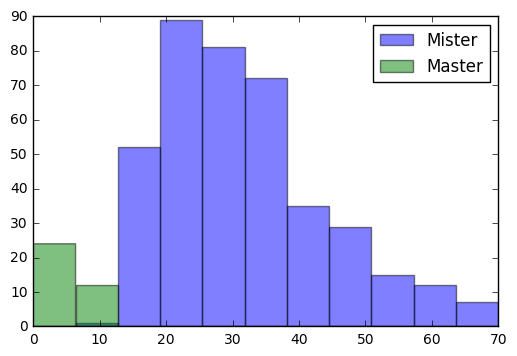

In [34]:
bins = np.linspace(0, 70, 12)

pyplot.hist(Mister['Age'], bins, alpha=.5, label='Mister')
pyplot.hist(Master['Age'], bins, alpha=.5, label='Master')
pyplot.legend(loc='upper right')
pyplot.show()

A large proportion of those with the Mister title are under 20 years old. Although there was a clear delination between married and unmarried female passengers (i.e. parenthesis in the name of the passenger) there are no obvious indicators of marriage for male passengers.

In [75]:
"""
The query below will match passengers where their first and last name's match.
The data that we are currently looking at is a sample of the titanic data, and therefore
nothing can be deduced from the results of this query. With a more complete dataset, this query
could help with analysis.
"""

pd.read_sql("""
    select 
        *
    From
        (
            select
                substr(Name, 0, instr(Name,',')) as NamePartOne,
                substr(Name, instr(Name,'.')+1, length(Name)) as NamePartTwo,
                SibSp,
                Parch,
                Name
            from titanic
            where 
                name LIKE "%Mr.%"
        ) as Mister
    JOIN
        (
            select
                substr(Name, 0, instr(Name,',')) as NamePartOne,
                substr(Name, instr(Name,'.')+1, length(Name)) as NamePartTwo,
                SibSp,
                Parch,
                Name
            from titanic
            where 
                name LIKE "%Mrs.%"
        ) as Misses
        ON Misses.NamePartOne = Mister.NamePartOne
            and Misses.NamePartTwo = Mister.NamePartTwo+"%"
    """, conn)

index          714
PassengerId    714
Survived       714
Pclass         714
Name           714
Sex            714
Age            714
SibSp          714
Parch          714
Ticket         714
Fare           714
Cabin          185
Embarked       712
Title          714
dtype: int64

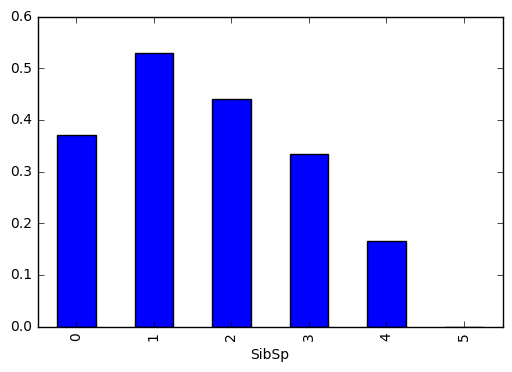

In [20]:
#titanic['SibSp'].value_counts().plot(kind ="bar", title ="Sibling/Spouse Distribution")
titanic[['SibSp','Survived']].groupby("SibSp")['Survived'].agg(np.mean).plot(kind ="bar")

## Formal Hypothesis testing

Now I will do some formal analysis of the features in the dataset.

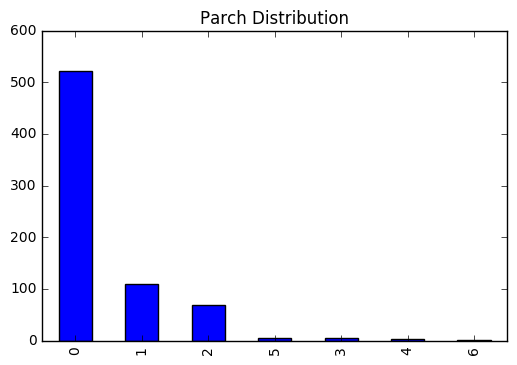

In [21]:
titanic['Parch'].value_counts().plot(kind ="bar", title ="Parch Distribution")

## Looking at the questions which I hope to answer, I see some of the relevant features of the data set are Age, Sex, and Pclass.

### I will test if there is a significant differents between the survival of males vs the survival of females in the titanic. Formally my hypthosis will be as follows

H<sub>0</sub>: Survival and gender are independent.

H<sub>1</sub>: Survival and gender are not independent.

[<matplotlib.text.Text at 0x1187ba278>, <matplotlib.text.Text at 0x1187c5588>]

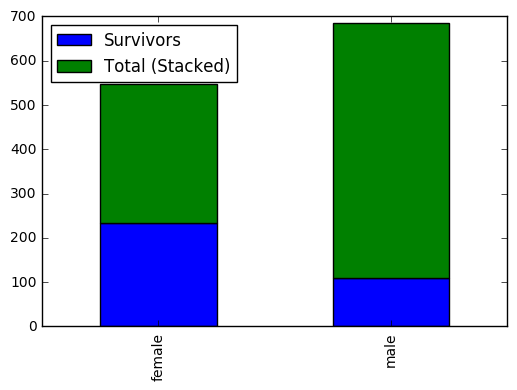

In [22]:
genderDF = pd.read_sql("""
    select
        Sex,
        sum(Survived) as Survivors,
        count(Survived) as "Total (Stacked)"
    from titanic
    group by Sex;
    """, conn)


ax = genderDF.plot(kind="bar", stacked= True)
ax.set_xticklabels(genderDF.Sex)

This graph shows that, while there were fewer females than males, a greater number of females survived than males. I will investigate whether this difference is statistically significant below.

In [76]:
pivot = pd.pivot_table(data = titanic[['Survived', 'Sex']], index = 'Survived', columns = ['Sex'], aggfunc = len)
print(pivot)
chi2, p_value, dof, expected = chi2_contingency(pivot)
print("Results of Chi-Squared test on Pclass to Survival.")
print("Does gender have a significant effect on Survival?")
print("Chi-Squared Score = " + str(chi2))
print("Pvalue = " + str(p_value))
print("\n")

Sex       female  male
Survived              
0             64   360
1            197    93
Results of Chi-Squared test on Pclass to Survival.
Does gender have a significant effect on Survival?
Chi-Squared Score = 205.025827529
Pvalue = 1.67166784414e-46




At the 99% confidence level, I must reject H<sub>0</sub> and Accept H<sub>a</sub> that survival and gender are not independent.

### I will test if there is a significant differents between the upper class and other passengers. Formally my hypthosis will be as follows

H<sub>0</sub>: Pclass and Surival rates are independent.

H<sub>1</sub>: Pclass and Survival rates are not independent.

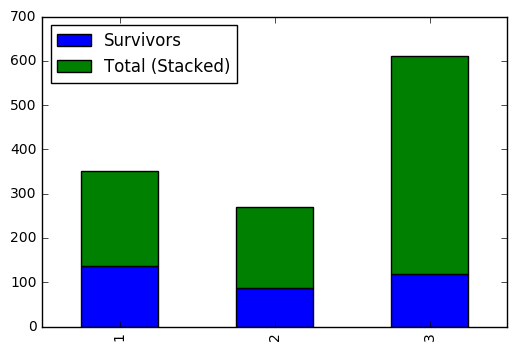

In [24]:
PclassDF = pd.read_sql("""
    select
        Pclass,
        sum(Survived) as Survivors,
        count(Survived) as "Total (Stacked)"
    from titanic
    group by Pclass;
    """, conn)


ax = PclassDF[['Survivors', 'Total (Stacked)']].plot(kind="bar", stacked= True)
ax.set_xticklabels(PclassDF.Pclass)

While third class passengers(which is a proxy for the patient's social standing) have a far greater total than 2nd or 1st class passengers, the number of survivors is roughly the same. I will test if this difference is statistically significant.

In [77]:
lower_class = pd.read_sql("""
    select
        Survived
    from titanic
    where 
        Pclass = 3;
    """, conn)
middle_class = pd.read_sql("""
    select
        Survived
    from titanic
    where 
        Pclass = 2;
    """, conn)
upper_class = pd.read_sql("""
    select
        Survived
    from titanic
    where 
        Pclass = 1;
    """, conn)
print(upper_class.describe())
print(middle_class.describe())
print(lower_class.describe())


         Survived
count  216.000000
mean     0.629630
std      0.484026
min      0.000000
25%      0.000000
50%      1.000000
75%      1.000000
max      1.000000
         Survived
count  184.000000
mean     0.472826
std      0.500623
min      0.000000
25%      0.000000
50%      0.000000
75%      1.000000
max      1.000000
         Survived
count  491.000000
mean     0.242363
std      0.428949
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      1.000000


In [79]:
pivot = pd.pivot_table(data = titanic[['Survived', 'Pclass']], index = 'Survived', columns = ['Pclass'], aggfunc = len)
pivot
print(pivot,"\n")


chi2, p_value, dof, expected = chi2_contingency(pivot)
print("Results of Chi-Squared test on Pclass to Survival.")
print("Does Pclass have a significant effect on Survival?")
print("Chi-Squared Score = " + str(chi2))
print("Pvalue = " + str(p_value))
print("\n")

Pclass      1   2    3
Survived              
0          64  90  270
1         122  83   85 

Results of Chi-Squared test on Pclass to Survival.
Does Pclass have a significant effect on Survival?
Chi-Squared Score = 92.9014172114
Pvalue = 6.70986174976e-21




At the 99% confidence level, I must reject H<sub>0</sub> and Accept H<sub>a</sub> that there is a statistically significant difference in survival rates

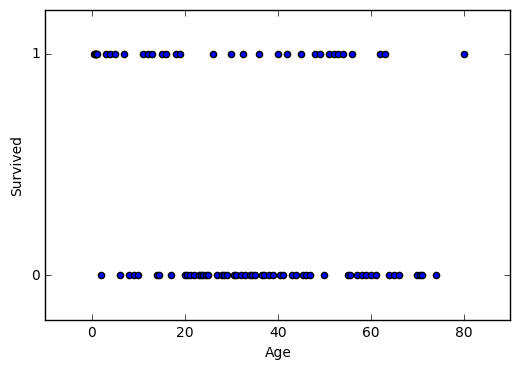

In [27]:
AgeDF = pd.read_sql("""
    select
        Age,
        Survived
    from titanic
    group by Age;
    """, conn)


ax = AgeDF.plot(kind="scatter", x="Age", y="Survived", yticks=[0,1])


### I will test if there is a significant differents between the survival of children vs adults. Formally my hypthosis will be as follows

H<sub>0</sub>: Age and survival are independent.

H<sub>1</sub>: Age and survival are not independent.

In [82]:
#titanic['Rounded_Age']=titanic['Age'].apply(lambda x : round(x,-1))
#print(titanic[['Survived','Age']].groupby('Age')['Survived'].count())

pivot = pd.pivot_table(data = titanic[['Survived', 'Age']], index = 'Survived', columns = ['Age'], aggfunc = len, fill_value=0)

print(pivot,"\n")


chi2, p_value, dof, expected = chi2_contingency(pivot)
print("Results of Chi-Squared test on Age to Survival.")
print("Does Age have a significant effect on Survival?")
print("Chi-Squared Score = " + str(chi2))
print("Pvalue = " + str(p_value))
print("\n")

Age       0.42   0.67   0.75   0.83   0.92   1.00   2.00   3.00   4.00   \
Survived                                                                  
0             0      0      0      0      0      2      7      1      3   
1             1      1      2      2      1      5      3      5      7   

Age       5.00   ...    62.00  63.00  64.00  65.00  66.00  70.00  70.50  \
Survived         ...                                                      
0             0  ...        2      0      2      3      1      2      1   
1             4  ...        2      2      0      0      0      0      0   

Age       71.00  74.00  80.00  
Survived                       
0             2      1      0  
1             0      0      1  

[2 rows x 88 columns] 

Results of Chi-Squared test on Age to Survival.
Does Age have a significant effect on Survival?
Chi-Squared Score = 104.156049889
Pvalue = 0.101411110189




At the 99% confidence level, I must reject H<sub>0</sub> and Accept H<sub>a</sub> that survival and age are not independent.

# Conclusion.

In conclusion, I have found that age, gender, and class all seemed to have a statistically significant relationship with the survival rate of passengers on the titanic.

Further I have explored some of the intricacies of titles in 1912 and have a greater sense of the underlying data.